In [2]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from db import helper as db_helper
from common import treat_data, extract_period_returns, reshape_df, extract_price_volatility
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
session = db_helper.start_session()
df = pd.read_sql_table('spot_rates', session.bind)

2019-05-06 12:30:09,451 INFO sqlalchemy.engine.base.Engine select version()
2019-05-06 12:30:09,452 INFO sqlalchemy.engine.base.Engine {}
2019-05-06 12:30:09,455 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-05-06 12:30:09,456 INFO sqlalchemy.engine.base.Engine {}
2019-05-06 12:30:09,459 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-06 12:30:09,460 INFO sqlalchemy.engine.base.Engine {}
2019-05-06 12:30:09,462 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-06 12:30:09,464 INFO sqlalchemy.engine.base.Engine {}
2019-05-06 12:30:09,466 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-05-06 12:30:09,467 INFO sqlalchemy.engine.base.Engine {}
2019-05-06 12:30:09,469 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind = 'r'
2019-05-06 12:

2019-05-06 12:30:09,590 INFO sqlalchemy.engine.base.Engine {}


/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
df = treat_data(df)
# Split DF by currency
gbp_df = df[(df['base_currency']=='GBP')]
usd_df = df[(df['base_currency']=='USD')]
eur_df = df[(df['base_currency']=='EUR')]

df = extract_period_returns(gbp_df)
df = extract_price_volatility(df)
df = reshape_df(df)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/JaiPancholi/Sites/currency_analysis/notebooks/common.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  currency_df['weekly_spot_rate_volatility'] = currency_df.rolling(

In [5]:
df = df.dropna()
# target_variable = 'USD_one_year_future_return'
target_variable = 'USD_one_month_future_return'
X = df.drop(columns=[target_variable, 'date'])
y = df[target_variable]
cols_to_drop = [col for col in X.columns if col.endswith('future_return')]
X = X.drop(columns=cols_to_drop)

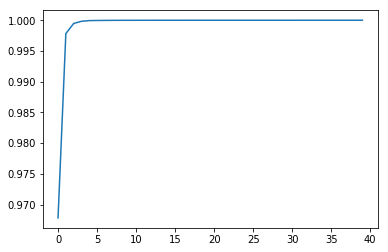

In [6]:
from sklearn.decomposition import PCA
pca = PCA()
X_r = pca.fit(X).transform(X)
sns.lineplot(x=range(X.shape[1]), y=pca.explained_variance_ratio_.cumsum())

In [ ]:
sns.scatterplot(x=X_r[:, 0], y=y)

In [ ]:
sns.scatterplot(x=X_r[:, 1], y=y)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Text(0.5,1,'R-Squared on Models Predicting Monthly Return on GBP:USD Rate')

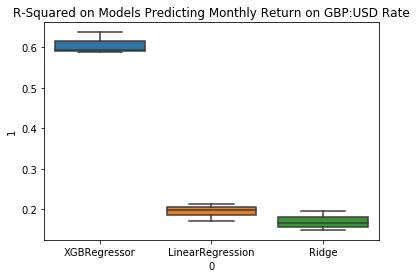

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = [
    XGBRegressor(),
    LinearRegression(),
    Ridge(),
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

k_folds = 3
model_scores = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='r2', cv=k_folds)
    for accuracy in accuracies:
        model_scores.append([model_name, accuracy])

df = pd.DataFrame(model_scores)
ax = sns.boxplot(x=0, y=1, data=df)
ax.set_title('R-Squared on Models Predicting Monthly Return on GBP:USD Rate')

In [7]:
from sklearn.metrics import r2_score
model = XGBRegressor()
model.fit(X_train, y_train)
y_test_hat = model.predict(X_test)
print(r2_score(y_test, y_test_hat))

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


0.6456432146437184


In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[1,:], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[500,:], X_test.iloc[500,:], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [8]:
import numpy as np
y_class = np.where(y < 0, 'Negative Return', 'Non-negative Return')

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
 

Text(0.5,1,'R-Squared on Models Predicting Sign of Monthly Return on GBP:USD Rate ')

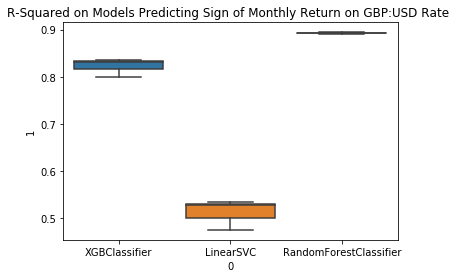

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = [
    XGBClassifier(),
    LinearSVC(),
#     MultinomialNB(),
#     LogisticRegression(random_state=0),
    RandomForestClassifier()
]

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.20, random_state=42)

k_folds = 3
model_scores = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=k_folds)
    for accuracy in accuracies:
        model_scores.append([model_name, accuracy])

df = pd.DataFrame(model_scores)
ax = sns.boxplot(x=0, y=1, data=df)
ax.set_title('R-Squared on Models Predicting Sign of Monthly Return on GBP:USD Rate ')

In [10]:
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_test_hat = model.predict(X_test)
print(accuracy_score(y_test, y_test_hat))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9117647058823529


In [12]:
np.unique(y_class, return_counts=True)

(array(['Negative Return', 'Non-negative Return'], dtype='<U19'),
 array([2904, 3212]))

Text(0.5,1,'Consusion Matrix of Classifying Sign of Monthly Return on GBP:USD')

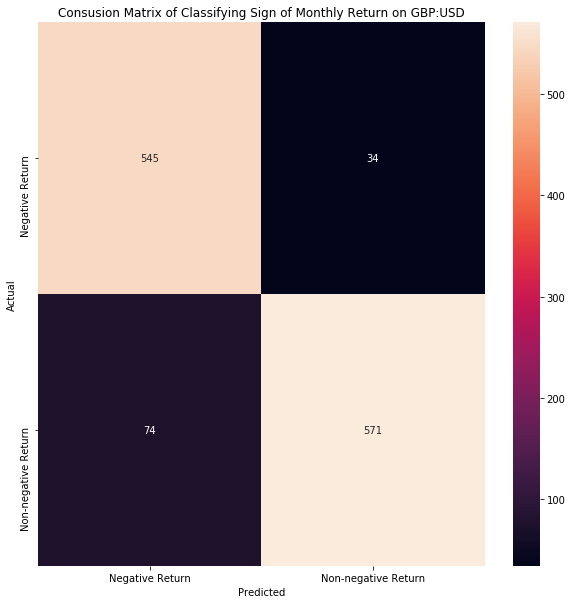

In [21]:
from sklearn.metrics import confusion_matrix
labels = np.unique(y_class)
cm = confusion_matrix(y_test, y_test_hat, labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Consusion Matrix of Classifying Sign of Monthly Return on GBP:USD')

In [22]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_hat))

                     precision    recall  f1-score   support

    Negative Return       0.88      0.94      0.91       579
Non-negative Return       0.94      0.89      0.91       645

          micro avg       0.91      0.91      0.91      1224
          macro avg       0.91      0.91      0.91      1224
       weighted avg       0.91      0.91      0.91      1224

